<a href="https://colab.research.google.com/github/Ramprabu95/AI_based_image_compression/blob/main/Learning_convolutional_Networks_for_Content_weighted_Image_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Convolutional Networks for Content Weighted Image Compression

# **Introduction:**


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda')
# Definition of convolution layer
def conv(ni, nf, kernal_size=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=kernal_size,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    nn.init.zeros_(_conv.bias)
    return _conv

# Definition of a residual block
class ResBlock(nn.Module):
  def __init__(self, ni, nh=128):
    super(ResBlock,self).__init__()
    self.conv1 = conv(ni, nh)
    self.conv2 = conv(nh, ni)
  def forward(self, x):
    return x  + self.conv2(F.relu(self.conv1(x)))

# Definition of Relu block
relu = nn.ReLU()

# Definition of encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.step1 = nn.Sequential(conv(3, 64, 8, 4, 2), relu,
                                   ResBlock(64), relu,
                                   conv(64, 256, 4, 2, 1), relu,
                                   ResBlock(256), relu,
                                   ResBlock(256), relu)
  def forward(self,x):
    x = self.step1(x)
    return(x)

# Function that does the binarizing action
class Binarizing_function(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    return (i>0.25).float()
  
  @staticmethod
  def backward(ctx,grad_output):
    return grad_output

def binary_value(x):
  return Binarizing_function.apply(x)

class Bin(nn.Module):
  def __init__(self,func):
    super(Bin,self).__init__()
    self.func = func

  def forward(self,x):
    return self.func(x)


# Quantizer of the importance map
class Quantizing(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    p_shape = i.shape
    p = i.clone().to(device)
    p = torch.reshape(p,(-1,)).to(device)
    #print(p.shape)
    L = 16
    for l in range(1,L):
      count = 0
      for q in p:
        #print('if condition',q, ((q<l/L) and (q>=(l+1)/L)))
        if((q<l/L) and (q>=(l-1)/L)):
          p[count] = l-1
        count = count +1
    p = torch.reshape(p,p_shape).to(device)
   # print('p is ',p.shape)
    return p
  @staticmethod
  def backward(ctx, grad_output):
    #N,Q,H,W = grad_output.shape
    return grad_output
  
def quantize_values(x):
  return Quantizing.apply(x)

class Masking(torch.autograd.Function):
  @staticmethod
  def forward(ctx,i):
    N,_,H,W = i.shape
    #print(i.shape)
    n = 128 # as per the paper
    L = 16 # as per the paper
    mask = torch.zeros(n,N*H*W).to(device)
    q_important = i
    q_important_flat = q_important.view(1, N*H*W)
    #print(q_important_flat.shape, q_important.shape)
    for index in range(n):
      count = 0
      for q in q_important_flat:
        mask[index,:] = torch.where(index <= (n/L)*q_important_flat[count],torch.Tensor([1]).to(device),torch.Tensor([0]).to(device))
      count = count +1
    mask = mask.view(N,n,H,W)
    #print(mask)
    return mask
  @staticmethod
  def backward(ctx, grad_output):
     N,Q,H,W = grad_output.shape
     #print(grad_output.shape)
     return grad_output
     
# function to generate mask
def generateMask(x):
  return Masking.apply(x)
  

# A decoder is to be defined which is a reverse of the encoder generated

class BitstoImage(torch.nn.Module):
  
  def __init__(self,blocksize):
    super(BitstoImage, self).__init__()
    self.blocksize = blocksize
  
  def forward(self,x):
    N,C,H,W = x.size()
    x = x.view(N, self.blocksize, self.blocksize,C // (self.blocksize ** 2), H, W)
    x = x.permute(0,3,4,1,5,2).contiguous()
    x = x.view(N, C // (self.blocksize ** 2), H*self.blocksize, W*self.blocksize)
    return x
# Definition of binarize 
class Encoder_full(nn.Module):
  def __init__(self,return_imp_map = False):
    super(Encoder_full,self).__init__()
    self.sig = nn.Sigmoid()
    # Layer that contains the binarizer
    self.step2 = nn.Sequential(conv(256,128,3,1,1),
                               nn.Sigmoid(),
                               Bin(binary_value))
    
    # Layer that contains the importance map 
    self.importance_map = nn.Sequential(conv(256,128),
                                        relu,
                                        conv(128,128),
                                        relu,
                                        conv(128,1),
                                        nn.Sigmoid())
    nn.init.xavier_normal_(self.step2[0].weight)
    nn.init.xavier_normal_(self.importance_map[4].weight)
  def forward(self,x,return_imp_map = False):
    if return_imp_map == True:
      x = self.importance_map(x)
      return x
    else:
      return self.step2(x)

# Decoder design for rebulding the encoded data
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # the convolution layers of a decoder is the reverse of the encoder
    self.decoder = nn.Sequential(conv(128,512,1,1,0), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    BitstoImage(2),
                                    conv(128,256), relu,
                                    ResBlock(256), relu,
                                    BitstoImage(4),
                                    conv(16,64), relu,
                                    conv(64,3))

  def forward(self,x):
    return self.decoder(x)

encoder_step1 = Encoder().to(device)
encoder_step2 = Encoder_full(False).to(device)
print('********************Encoder Parameters***********************')
importance_map_full = Encoder_full(True).to(device)
print('********************Importance Map Parameters***********************')
print(importance_map_full.parameters)
decoder_full = Decoder().to(device)
print('********************Decoder Parameters***********************')
print(decoder_full.parameters)

********************Encoder Parameters***********************
********************Importance Map Parameters***********************
<bound method Module.parameters of Encoder_full(
  (sig): Sigmoid()
  (step2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Bin()
  )
  (importance_map): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)>
********************Decoder Parameters***********************
<bound method Module.parameters of Decoder(
  (decoder): Sequential(
    (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 512, ke

In [4]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


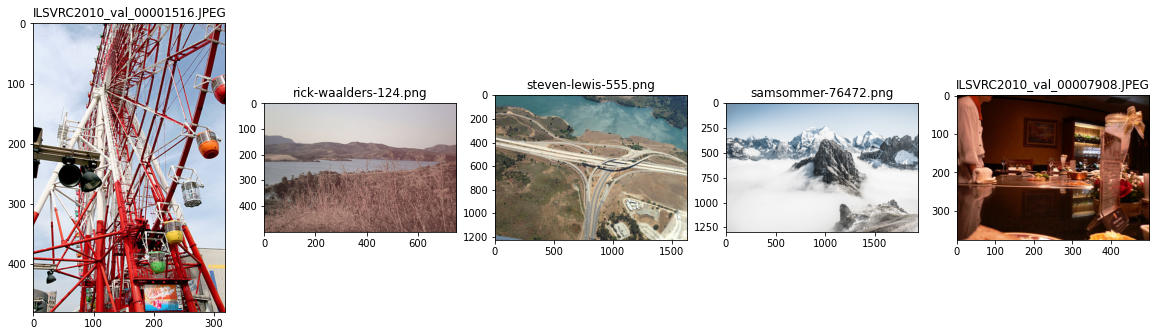

In [5]:
import os 
import random                                                                     
dir_root = '/content/drive/MyDrive/Colab Notebooks/'    
train_dir = os.path.join(dir_root, 'train (1)') 
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(train_dir))
    image_path= os.path.join(train_dir, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [6]:
from PIL import Image
TRAIN_TRANSFORMS_256 = transforms.Compose([transforms.RandomResizedCrop(256),
                                                   transforms.ToTensor()])
def load_image(path):
    return Image.open(path).convert("RGB")
def create_dataset(img_folder):
    count = 0
    img_data_array=[]
    for file in os.listdir(img_folder):
        count = count+ 1
        image_path= os.path.join(img_folder,  file)
        image= load_image(image_path)
        image_tensor = TRAIN_TRANSFORMS_256(image).to(device)
        img_data_array.append(image_tensor)
        if(count%100 ==0):
          print(count)
    return img_data_array
# extract the image array and class name
train_img_data =create_dataset(train_dir)
train_loader = torch.utils.data.DataLoader(train_img_data, batch_size=1, shuffle=True)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


In [7]:
def loss_fn(input,output,imp_map):
  rate_loss = nn.MSELoss()
  dist_loss = torch.sum(imp_map)
  loss = torch.sqrt(rate_loss(input,output))
  return loss

In [8]:
import argparse
import torch
import torch.nn
from torch.utils.data import DataLoader
import os
from torchvision.utils import save_image

class full_layers(nn.Module):
  def __init__(self):
        super(full_layers, self).__init__()
        self.encoder = Encoder()
        self.encoder_rest = Encoder_full()
        self.imp_map_gen = Encoder_full(True)
        self.decoder = Decoder()     
  def forward(self,x):
    #print(x.shape)
    inter_result = self.encoder(x)
    importance_map = self.imp_map_gen(inter_result, True)
    quantized_op = quantize_values(importance_map).to(device)
    #print(quantized_op)
    masked_op = generateMask(quantized_op).to(device)
    op1 = binary_value(self.encoder_rest(inter_result)).to(device)
    op2 = masked_op.to(device)
    #print(op1.shape,op2.shape)
    y = (op1+op2).to(device)
    return self.decoder(y), importance_map

fullnet = full_layers().to(device)
print(fullnet.parameters)
fullnet.eval()
return_imp_map = False
for p in fullnet.imp_map_gen.parameters():
  p.requires_grad_ = False
optimizer = torch.optim.Adam(fullnet.parameters(), lr=0.0001)
running_loss = 0.0
trial = [[[]]]
for epoch in range(9):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    trial = inputs
    #print(inputs.shape)
    inputs = Variable(inputs)
    optimizer.zero_grad()
    for p in fullnet.imp_map_gen.parameters():
      p.requires_grad = False
      #print (p)
    output = fullnet(inputs)
    imp_map = output[1]
    #print(imp_map)
    output = output[0]
    loss = loss_fn(output, inputs,imp_map)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%10 == 9:
      print('[%5d epoch] loss: %.3f'% (epoch+1,running_loss/10))
      running_loss = 0.0
print('Training completed')

print('Learnig Concolutional Networks for content-weighted image compression')
print('Step1 : Loading of the training data')

print('Step2 : Training of the encode created')
print('Step3 : Training of the importance map generator')
print('Step4 : Testing the compression')
PATH = './cifar_net.pth'
torch.save(fullnet.state_dict(), PATH)


<bound method Module.parameters of full_layers(
  (encoder): Encoder(
    (step1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
      (1): ReLU()
      (2): ResBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): ReLU()
      (4): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): ResBlock(
        (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (7): ReLU()
      (8): ResBlock(
        (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (9): ReLU()
    )
  )
  (encoder_rest): Encoder_full(
    (sig): Sigmoid()
   

tensor([[[0.2165, 0.2550, 0.2454,  ..., 0.1556, 0.1945, 0.2393],
         [0.2009, 0.2006, 0.1891,  ..., 0.1527, 0.1693, 0.2354],
         [0.3334, 0.1064, 0.1820,  ..., 0.1178, 0.1450, 0.2348],
         ...,
         [0.2254, 0.2791, 0.2332,  ..., 0.0390, 0.0839, 0.1501],
         [0.3270, 0.3582, 0.3149,  ..., 0.1061, 0.2549, 0.1922],
         [0.3752, 0.5064, 0.4052,  ..., 0.2126, 0.2502, 0.3267]]],
       device='cuda:0', grad_fn=<SqueezeBackward3>)


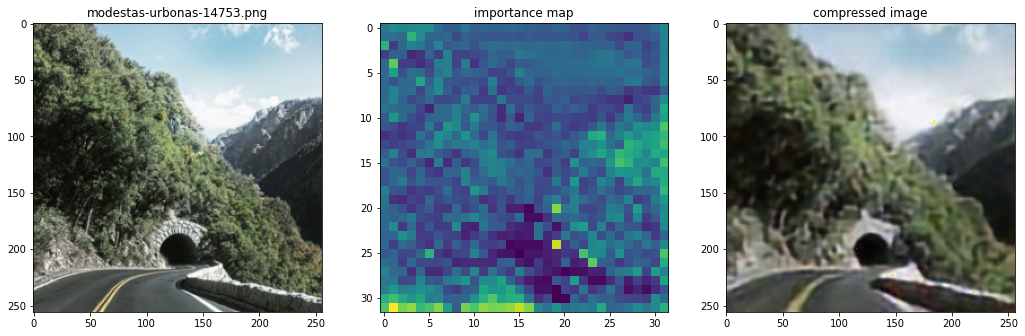

In [62]:
import os 
import random     
from PIL import Image
fullnet = full_layers().to(device)
fullnet.load_state_dict(torch.load(PATH))
dir_root = '/content/drive/MyDrive/Colab Notebooks/'    
train_dir = os.path.join(dir_root, 'train (1)') 
TRAIN_TRANSFORMS_reverse = transforms.Compose([transforms.ToPILImage()])
plt.figure(figsize=(30,30))
for i in range(1):
  file = random.choice(os.listdir(train_dir))
  image_path= os.path.join(train_dir, file)
  image= load_image(image_path)
  image_tensor = TRAIN_TRANSFORMS_256(image)
  inputs = image_tensor.unsqueeze(0)
  inputs = Variable(inputs.to(device))
  output = fullnet(inputs)[0]
  map = fullnet(inputs)[1]
  ax=plt.subplot(1,5,i+1)
  ax.title.set_text(file)
  plt.imshow(TRAIN_TRANSFORMS_reverse(image_tensor.squeeze_(0)))
  ax=plt.subplot(1,5,i+2)
  ax.title.set_text("importance map")
  #print(activation['imp_map'].shape,output.shape)
  plt.imshow(TRAIN_TRANSFORMS_reverse(map.squeeze_(0)))
  ax=plt.subplot(1,5,i+3)
  ax.title.set_text("compressed image")
  plt.imshow(TRAIN_TRANSFORMS_reverse(output.squeeze_(0)))
  print(map)
  #print(output[0])